In [1]:
import torch
from torchvision import transforms as T

import requests # for loading images from web
from PIL import Image, ImageDraw # for viewing images and drawing bounding boxes

from IPython.display import display, Markdown, Latex
from termcolor import colored

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

/Users/arturopolancolozano/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/arturopolancolozano/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <31D2ED80-D446-353A-885A-F2032D05B554> /Users/arturopolancolozano/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <67E63A8C-D186-3C67-A94C-3D719DCACA79> /Users/arturopolancolozano/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
model = torch.hub.load('facebookresearch/detr','detr_resnet50',pretrained=True)

if torch.cuda.is_available():
  torch.device('cuda')
  model = model.cuda()

Using cache found in /Users/arturopolancolozano/.cache/torch/hub/facebookresearch_detr_main
/Users/arturopolancolozano/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

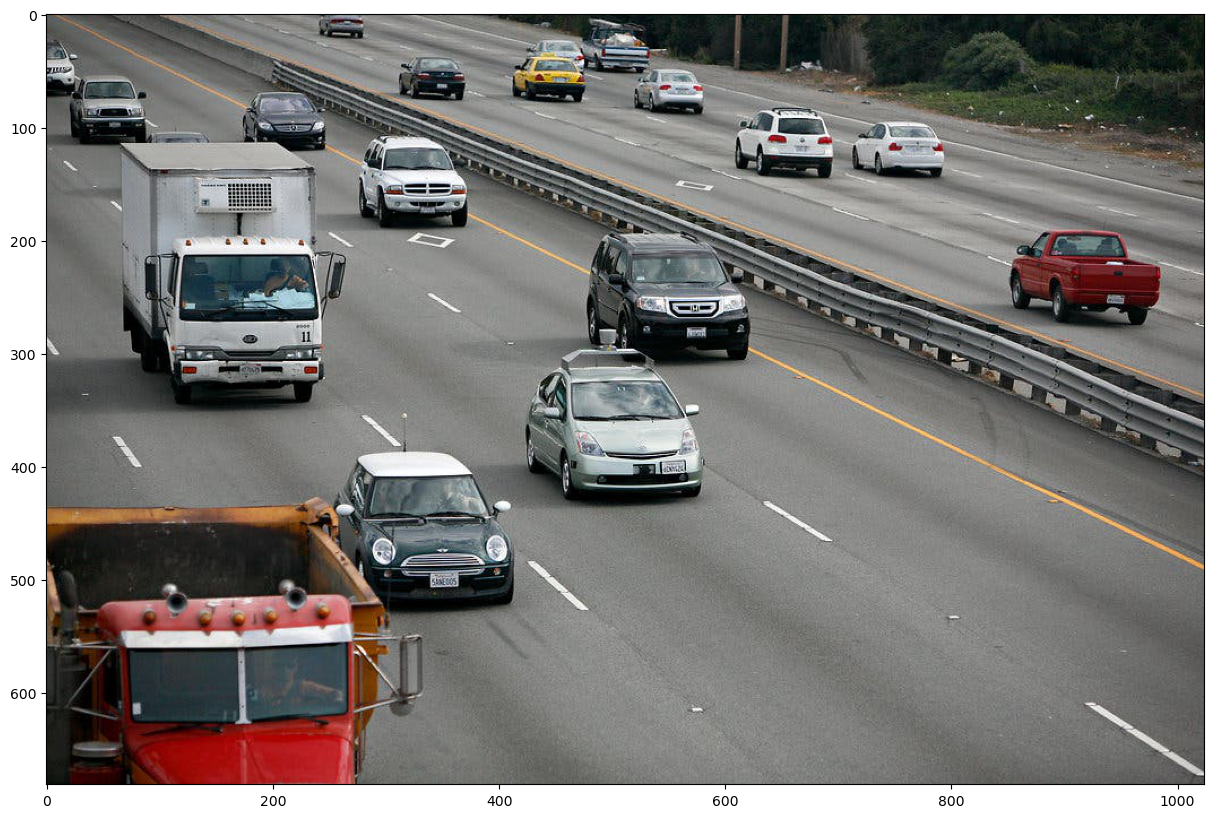

In [4]:
#@title Display Image
# url = "https://i.vimeocdn.com/video/751597323-3057e0a149a649e92a689d23e47342bf322e2390fb87fd6f3c6c3a995126d8ce-d_640?f=webp"
url = "https://static01.nyt.com/images/2010/10/10/us/10google2/10google2-jumbo.jpg?quality=75&auto=webp&disable=upscale"
im = Image.open(requests.get(url, stream=True).raw)
fig = plt.figure(figsize=(15,10))
plt.imshow(im)
plt.show()

In [5]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

img_tensor = transform(im)

In [6]:
# COCO classes
CLASSES = ['N/A', 'Person', 'Bicycle', 'Car', 'Motorcycle', 'Airplane', 'Bus',
           'Train', 'Truck', 'Boat', 'Traffic-Light', 'Fire-Hydrant', 'N/A', 'Stop-Sign',
           'Parking Meter', 'Bench', 'Bird', 'Cat', 'Dog', 'Horse', 'Sheep', 'Cow', 'Elephant',
           'Bear', 'Zebra', 'Giraffe', 'N/A', 'Backpack', 'Umbrella', 'N/A', 'N/A', 'Handbag',
           'Tie', 'Suitcase', 'Frisbee', 'Skis', 'Snowboard', 'Sports-Ball', 'Kite', 'Baseball Bat',
           'Baseball Glove', 'Skateboard', 'Surfboard', 'Tennis Racket', 'Bottle', 'N/A',
           'Wine Glass', 'Cup', 'Fork', 'Knife', 'Spoon', 'Bowl', 'Banana', 'Apple', 'Sandwich',
           'Orange', 'Broccoli', 'Carrot', 'Hot-Dog', 'Pizza', 'Donut', 'Cake', 'Chair', 'Couch',
           'Potted Plant', 'Bed', 'N/A', 'Dining Table', 'N/A','N/A', 'Toilet', 'N/A', 'TV', 'Laptop',
           'Mouse', 'Remote', 'Keyboard', 'Cell-Phone', 'Microwave', 'Oven', 'Toaster',
           'Sink', 'Refrigerator', 'N/A', 'Book', 'Clock', 'Vase', 'Scissors', 'Teddy-Bear',
           'Hair-Dryer', 'Toothbrush']

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [7]:
len(CLASSES)

91

In [8]:
# select labels of interest for the project
project_detection_labels = [
    # 'Person', 
    'Bicycle', 
    'Car', 
    'Motorcycle', 
    'Bus',       
    'Truck'
]

# subtract their indices in the CLASES list
project_index_labels = []

for label in project_detection_labels:
    index = CLASSES.index(label)
    project_index_labels.append(index)

print(project_index_labels)

[2, 3, 4, 6, 8]


In [9]:
detection_counter = {}

for label in project_detection_labels:
    detection_counter[label] = 0

print(detection_counter)


{'Bicycle': 0, 'Car': 0, 'Motorcycle': 0, 'Bus': 0, 'Truck': 0}


In [10]:
colors_list = [
    [255, 0, 0], 
    [0, 255, 0], 
    [0, 0, 255], 
    [0, 0, 0], 
    [128, 128, 128]
]

colors_list = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188]]

color_labels_dict = {}

for label, color in zip(project_detection_labels, colors_list):
    color_labels_dict[label] = color

color_labels_dict

{'Bicycle': [0.0, 0.447, 0.741],
 'Car': [0.85, 0.325, 0.098],
 'Motorcycle': [0.929, 0.694, 0.125],
 'Bus': [0.494, 0.184, 0.556],
 'Truck': [0.466, 0.674, 0.188]}

In [11]:
detection_counter = {}

for label in project_detection_labels:
    detection_counter[label] = 0

print(detection_counter)

{'Bicycle': 0, 'Car': 0, 'Motorcycle': 0, 'Bus': 0, 'Truck': 0}


In [12]:
# Get coordinates (x0, y0, x1, y0) from model output (x, y, w, h)
def get_box_coords(boxes):
    x, y, w, h = boxes.unbind(1)
    x0, y0 = (x - 0.5 * w), (y - 0.5 * h)
    x1, y1 = (x + 0.5 * w), (y + 0.5 * h)
    box = [x0, y0, x1, y1]
    return torch.stack(box, dim=1)

In [13]:
# Scale box from [0,1] x [0,1] to [0, width] x [0, height]
def scale_boxes(output_box, width, height):
  box_coords = get_box_coords(output_box)
  scale_tensor = torch.Tensor([width, height, width, height]).to(device)
  return box_coords * scale_tensor

In [14]:
def detect(im, model, transform):

    width = im.size[0]
    height = im.size[1]
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)
    img = img.to(device)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.85

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = scale_boxes(outputs['pred_boxes'][0, keep], width, height)
    return probas[keep], bboxes_scaled

In [15]:
probs, bboxes = detect(im, model, transform)
output=model(img_tensor.unsqueeze(0).to(device))

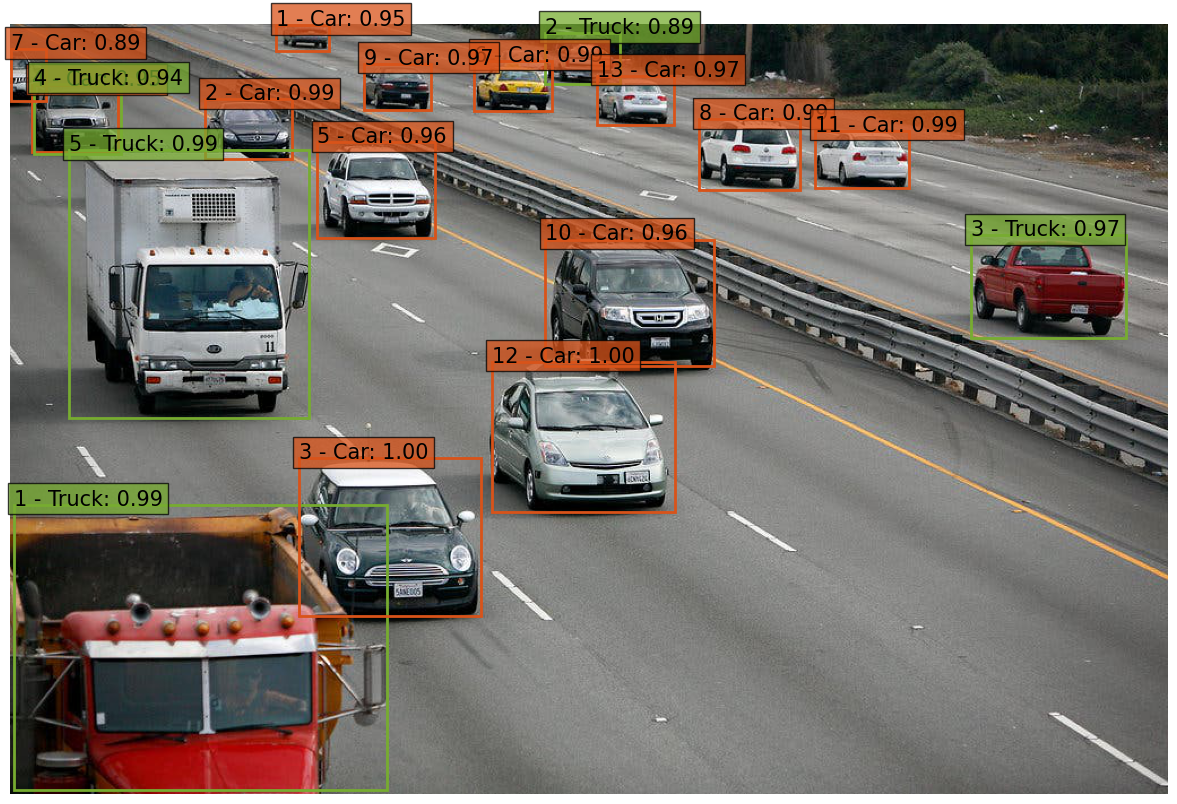

In [16]:
def annotate_detected_vehicles(pil_img, prob, boxes,labels=True):
    
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)

    ax = plt.gca()

    labels_counter = detection_counter.copy()

    for prob, (x0, y0, x1, y1) in zip(prob, boxes.tolist()):
        
        index_class = prob.argmax()
        index_class = int(index_class)

        class_label = CLASSES[index_class]
        prediction_proba = prob[index_class]

        if index_class not in project_index_labels:
           continue
        
        color = color_labels_dict[class_label] 
        
        ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0,
                                   fill=False, color=color, linewidth=2))
        
        
        labels_counter[class_label] += 1
        counter_value = labels_counter[class_label]

        text = f'{counter_value} - {class_label}: {prediction_proba:0.2f}'

        if labels:
          ax.text(x0, y0, text, fontsize=15,
                bbox=dict(facecolor=color, alpha=0.75))
    plt.axis('off')
    plt.savefig(
       'annotated_image.png', 
       bbox_inches='tight'
    )
    return labels_counter


output_count = annotate_detected_vehicles(im, probs, bboxes)

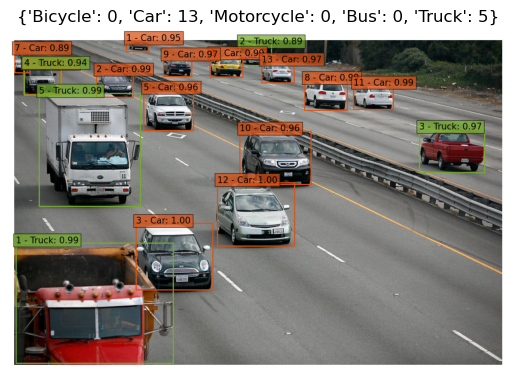

In [17]:
output_image = mpimg.imread("annotated_image.png")
plt.imshow(output_image)
plt.title(output_count)
plt.title(str(output_count))
plt.axis(False);